## 什么是Alpha101?
*用数学公式找到Alpha机会*

## 目录

1. Alpha101是什么？
2. Alpha101用到的算法有哪些？
3. Alpha001-010怎么写？
4. 用柱图展示因子绩效
5. 如何用TA_Lib设计新的Alpha因子？

## Alpha101是什么？
WorldQuant根据数据挖掘的方法发掘了101个alpha，据说里面 80% 的因子仍然还行之有效并运行在他们的投资策略中。Alpha101给出的公式，也就是计算机代码101年真实的定量交易Alpha。他们的平均持有期大约范围0.6 - 6.4天。平均两两这些Alpha的相关性较低,为15.9%。回报是与波动强相关，但对换手率没有明显的依赖性，直接确认较早的间接经验分析结果。我们从经验上进一步发现换手率对alpha相关性的解释能力很差。

PDF下载：

Python代码下载：## Alpha101主要元素有什么？
### 1. 因子组成元素
- 价量因子（52/101）：
    - HLOC
    - ADV
    - VWAP
    - Volume
- 价格波动因子（21/101）:
    - HLOC
    - Return
    - STD()
- 组合因子(8/101): 价量与价波因子组合
- 市值因子（1/101）:
    - Return
    - Cap
- 板块组合因子（19/101）: 板块分类结合价量与价波因子

### 2. 函数与运算符
- 'x?y:z'是指x为True，返回y，否则返回z。
- Rank是指横向的品种间排序。
- ts_Rank是指纵向的时间序列排序。

详细参考原文PDF

## Alpha101用到的算法有哪些？
### Step1 编制函数需要的算法

In [1]:
# 1. 编制函数需要的算法，
#coding=utf-8
import numpy as np
import pandas as pd
from scipy.stats import rankdata

# 计算alpha101时会使用的函数
# 移动求和
def ts_sum(df,window=10):
    return df.rolling(window).sum()

#移动平均
def ts_mean(df,window=10):
    return df.rolling(window).mean()

#移动标准差
def stddev(df,window=10):
    return df.rolling(window).std()

#移动相关系数
def correlation(x,y,window=10):
    return x.rolling(window).corr(y)

#移动协方差
def covariance(x,y,window=10):
    return x.rolling(window).cov(y)


def rolling_rank(na):
    return rankdata(na)[-1]

#移动排序
def ts_rank(df, window=10):
    return df.rolling(window).apply(rolling_rank)

def rolling_prod(na):
    return na.prod(na)

#移动乘积
def product(df,window=10):
    return df.rolling(window).apply(rolling_prod)

# 移动窗口最小值
def ts_min(df,window=10):
    return df.rolling(window).min()

# 移动窗口最大值
def ts_max(df,window=10):
    return df.rolling(window).max()

# 差值
def delta(df,period=1):
    return df.diff(period)

# 位移
def delay(df,period=1):
    return df.shift(period)

# 横向排序
def rank(df):
    return df.rank(axis=1, pct=True)

# 数值规模
def scale(df,k=1):
    return df.mul(k).div(np.abs(df).sum())

# 最大值的坐标
def ts_argmax(df,window=10):
    return df.rolling(window).apply(np.argmax)+1

# 最小值的坐标
def ts_argmin(df,window=10):
    return df.rolling(window).apply(np.argmin)+1

# 加权平均
def decay_linear(df,period=10):
    if df.isnull().values.any():
        df.fillna(method='ffill',inplace=True)
        df.fillna(method='bfill',inplace=True)
        df.fillna(value=0, inplace=True)
    return pd.DataFrame(
        {name: ta.WMA(item.values, period) for name, item in df.iteritems()},
        index=df.index
    )

In [2]:
# 2. 定义计算alpha值的类
class alphas(object):
    def __init__(self, pn_data):
        """
        :传入参数 pn_data: pandas.Panel
        """
        # 获取历史数据
        self.open = pd.DataFrame(pn_data.minor_xs('open'), dtype=np.float64)
        self.high = pd.DataFrame(pn_data.minor_xs('high'), dtype=np.float64)
        self.low = pd.DataFrame(pn_data.minor_xs('low'), dtype=np.float64)
        self.close = pd.DataFrame(pn_data.minor_xs('close'), dtype=np.float64)
        self.volume = pd.DataFrame(pn_data.minor_xs('volume'), dtype=np.float64)
        self.returns = pd.DataFrame(self.close.pct_change())
        self.adv = ts_mean(self.volume, 10)
        self.vwap = ts_sum(self.close*self.volume, 10)/ts_sum(self.volume, 10)

# 3. 编制因子的函数
    
    #   alpha001:(rank(Ts_ArgMax(SignedPower(((returns < 0) ? stddev(returns, 20) : close), 2.), 5)) -0.5)
    def alpha001(self):
        inner = self.close
        inner[self.returns < 0] = stddev(self.returns, 20)
        alpha = rank(ts_argmax(inner ** 2, 5))
        return alpha
    
    #  alpha002:(-1 * correlation(rank(delta(log(volume), 2)), rank(((close - open) / open)), 6))
    def alpha002(self):
        alpha = -1 * correlation(rank(delta(np.log(self.volume), 2)), rank((self.close - self.open) / self.open), 6)
        return alpha.replace([-np.inf, np.inf], np.nan)

    # alpha003:(-1 * correlation(rank(open), rank(volume), 10))
    def alpha003(self):
        alpha = -1 * correlation(rank(self.open), rank(self.volume), 10)
        return alpha.replace([-np.inf, np.inf], np.nan)

    # alpha004: (-1 * Ts_Rank(rank(low), 9))
    def alpha004(self):
        alpha = -1 * ts_rank(rank(self.low), 9)
        return alpha
    
    # alpha005:(rank((open - (sum(vwap, 10) / 10))) * (-1 * abs(rank((close - vwap)))))
    def alpha005(self):
        alpha = (rank((self.open - (ts_sum(self.vwap, 10) / 10))) * (-1 * np.abs(rank((self.close - self.vwap)))))
        return alpha
    
    # alpha006: (-1 * correlation(open, volume, 10))
    def alpha006(self):
        alpha = -1 * correlation(self.open, self.volume, 10)
        return alpha
        
    # alpha007: ((adv20 < volume) ? ((-1 * ts_rank(abs(delta(close, 7)), 60)) * sign(delta(close, 7))) : (-1* 1))
    def alpha007(self):
        adv20 = ts_mean(self.volume, 20)
        alpha = -1 * ts_rank(abs(delta(self.close, 7)), 60) * np.sign(delta(self.close, 7))
        alpha[adv20 >= self.volume] = -1
        return alpha

    # alpha008: (-1 * rank(((sum(open, 5) * sum(returns, 5)) - delay((sum(open, 5) * sum(returns, 5)),10))))
    def alpha008(self):
        alpha = -1 * (rank(((ts_sum(self.open, 5) * ts_sum(self.returns, 5)) -
                          delay((ts_sum(self.open, 5) * ts_sum(self.returns, 5)), 10))))
        return alpha
    
    # alpha009:((0 < ts_min(delta(close, 1), 5)) ? delta(close, 1) : ((ts_max(delta(close, 1), 5) < 0) ?delta(close, 1) : (-1 * delta(close, 1))))
    def alpha009(self):
        delta_close = delta(self.close, 1)
        cond_1 = ts_min(delta_close, 5) > 0
        cond_2 = ts_max(delta_close, 5) < 0
        alpha = -1 * delta_close
        alpha[cond_1 | cond_2] = delta_close
        return alpha

    # alpha010: rank(((0 < ts_min(delta(close, 1), 4)) ? delta(close, 1) : ((ts_max(delta(close, 1), 4) < 0)? delta(close, 1) : (-1 * delta(close, 1)))))
    def alpha010(self):
        delta_close = delta(self.close, 1)
        cond_1 = ts_min(delta_close, 4) > 0
        cond_2 = ts_max(delta_close, 4) < 0
        alpha = -1 * delta_close
        alpha[cond_1 | cond_2] = delta_close
        return alpha

### Step2 获取股票池

In [3]:
# 4. 传入股票池数据
if __name__ == '__main__':
    from fxdayu_data import DataAPI
    from datetime import datetime
    import tushare as ts
    import numpy as np
    import matplotlib.pyplot as plt
    import pandas as pd
    import alphalens
    
    #输入config的位置
    DataAPI.set_file('D:/PycharmProjects/Quant_Alpha/Data_Manager/Factor_Selection/config.py')

    #改名字的方法
    def coder(code):
        if code.startswith('6'):
            return code + '.XSHG'
        elif code.startswith('0') or code.startswith('3'):
            return code + '.XSHE'
        else:
            return code
    
    #获取沪深300的股票名
    name = ts.get_hs300s()
    name_list = list(name.code)
    codes = tuple(map(coder, name_list))
    print(codes)

('002230.XSHE', '002299.XSHE', '601225.XSHG', '002174.XSHE', '601727.XSHG', '600019.XSHG', '601127.XSHG', '002385.XSHE', '601216.XSHG', '300070.XSHE', '000709.XSHE', '002074.XSHE', '600074.XSHG', '000983.XSHE', '300133.XSHE', '300072.XSHE', '601118.XSHG', '300059.XSHE', '000826.XSHE', '300144.XSHE', '600867.XSHG', '300024.XSHE', '002131.XSHE', '002152.XSHE', '600188.XSHG', '600010.XSHG', '600009.XSHG', '000792.XSHE', '300002.XSHE', '600048.XSHG', '002739.XSHE', '300017.XSHE', '300033.XSHE', '000778.XSHE', '600271.XSHG', '300058.XSHE', '601258.XSHG', '601600.XSHG', '300251.XSHE', '000060.XSHE', '600383.XSHG', '600875.XSHG', '002146.XSHE', '600111.XSHG', '600256.XSHG', '601933.XSHG', '600873.XSHG', '600446.XSHG', '300027.XSHE', '000027.XSHE', '000425.XSHE', '600583.XSHG', '300168.XSHE', '002153.XSHE', '601021.XSHG', '000977.XSHE', '000555.XSHE', '000402.XSHE', '002183.XSHE', '600352.XSHG', '600157.XSHG', '000876.XSHE', '600582.XSHG', '601611.XSHG', '000800.XSHE', '000630.XSHE', '600718.X

### Step3 读取数据并计算IC值

In [4]:
    PN = DataAPI.factor(codes, ('open', 'high', 'low', 'close', 'volume'), start=datetime(2013, 1, 1))
    prices = PN.minor_xs('close')
    print PN

<class 'pandas.core.panel.Panel'>
Dimensions: 300 (items) x 1077 (major_axis) x 5 (minor_axis)
Items axis: 000001.XSHE to 603993.XSHG
Major_axis axis: 2013-01-04 15:00:00 to 2017-06-13 15:00:00
Minor_axis axis: close to volume


In [5]:
    from collections import OrderedDict
    
    alpha = alphas(PN)
    factors = {'one': alpha.alpha001(),
               'two': alpha.alpha002(),
               'three': alpha.alpha003(),
               'four': alpha.alpha004(),
               'five': alpha.alpha005(),
               'six': alpha.alpha006(),
               'seven': alpha.alpha007(),
               'eight': alpha.alpha008(),
               'nine': alpha.alpha009(),
               'ten': alpha.alpha010()}


    def cal_monthly_ic(factor):
        factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor.stack(), prices, quantiles=5)
        return alphalens.performance.mean_information_coefficient(factor_data, by_time='M')

    monthly_ic = {key: cal_monthly_ic(value) for key, value in factors.items()}

    monthly_ic_mean = pd.DataFrame(
        map(lambda frame: frame.mean(), monthly_ic.values()),
        monthly_ic.keys()
    )
    print monthly_ic_mean

             1         5         10
seven  0.214916  0.230020  0.225757
ten    0.382698  0.427790  0.418241
nine   0.407941  0.453681  0.450126
six    0.027573  0.033777  0.041094
three  0.005634  0.010449  0.015037
two    0.035391  0.034132  0.008091
four   0.064523  0.065857  0.060070
eight  0.112418  0.104459  0.086828
five   0.301093  0.303139  0.299830
one   -0.192433 -0.201775 -0.191760


In [6]:
    monthly_ic_std = pd.DataFrame(
        map(lambda frame: frame.std(), monthly_ic.values()),
        monthly_ic.keys()
    )
    print monthly_ic_std

             1         5         10
seven  0.059689  0.062802  0.058519
ten    0.070118  0.061659  0.084437
nine   0.085144  0.078367  0.071449
six    0.021528  0.024599  0.020430
three  0.013544  0.016175  0.019742
two    0.066674  0.082584  0.076191
four   0.045066  0.031038  0.032137
eight  0.045690  0.050938  0.046118
five   0.085040  0.074704  0.048871
one    0.042129  0.042742  0.042589


### Step4 用柱图显示IC的均值与标准差

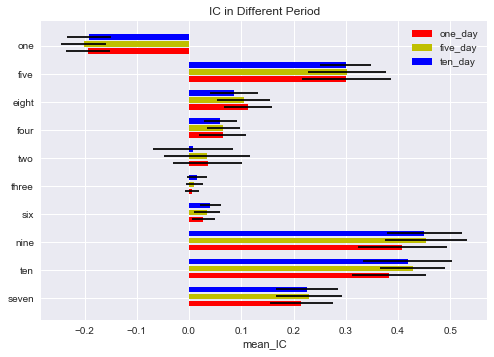

In [7]:
    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots()
    N=10
    ind = np.arange(N)  # the x locations for the groups
    width = 0.3       # the width of the bars
    # Example data
    ind_name = tuple(monthly_ic_mean.index)
    y_pos = np.arange(len(ind))
    one_mean = monthly_ic_mean.iloc[:,0]
    one_std = monthly_ic_std.iloc[:,0]
    five_mean = monthly_ic_mean.iloc[:,1]
    five_std = monthly_ic_std.iloc[:,1]
    ten_mean = monthly_ic_mean.iloc[:,2]
    ten_std = monthly_ic_std.iloc[:,2]

    ax.barh(ind - width, one_mean, align='edge',height=0.2, xerr=one_std,
            color='r', label='one_day')
    ax.barh(ind - 0.05, five_mean, align='edge',height=0.2,xerr=five_std,
            color='y', label='five_day')
    ax.barh(ind + width, ten_mean, align='center',height=0.2,xerr=ten_std,
            color='b', label='ten_day')

    ax.set_yticks(y_pos)
    ax.set_yticklabels(ind_name)
#     ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('mean_IC')
    ax.set_title('IC in Different Period')
    plt.legend()
    plt.show()

## 如何用TA_Lib设计新的Alpha因子？
加入slope技术指标

In [8]:
import talib as ta
import numpy as np

def slope(df, period=10):
    return pd.DataFrame(
        {name: ta.LINEARREG_SLOPE(item.values, period) for name, item in df.iteritems()},
        index=df.index
        )

class alphas(object):
    def __init__(self, pn_data):
        self.close = pd.DataFrame(pn_data.minor_xs('close'), 
                                  dtype=np.float64)

# 自制因子
    def slope001(self):
        alpha = -1 * slope(self.close)
        return alpha

print alphas(PN).slope001().tail(5)

                     000001.XSHE  000002.XSHE  000008.XSHE  000009.XSHE  \
datetime                                                                  
2017-06-07 15:00:00     0.468032          NaN    -0.825076    -0.508490   
2017-06-08 15:00:00     0.150155          NaN    -0.391822    -0.295820   
2017-06-09 15:00:00    -0.166025          NaN    -0.356104    -0.475409   
2017-06-12 15:00:00     0.001076          NaN    -0.311639    -0.243290   
2017-06-13 15:00:00    -0.438850          NaN    -0.274481    -0.028803   

                     000027.XSHE  000039.XSHE  000060.XSHE  000061.XSHE  \
datetime                                                                  
2017-06-07 15:00:00    -0.527817    -0.964975    -0.730131    -0.581137   
2017-06-08 15:00:00    -0.494012    -0.508576    -0.559069    -0.925861   
2017-06-09 15:00:00    -0.382459     0.025234    -0.365330    -0.172980   
2017-06-12 15:00:00    -0.256944     0.354929    -0.308335     0.580023   
2017-06-13 15:00:00    -

## 读取五号因子选中的股票池

In [23]:
factor_005 = alpha.alpha005().stack()

factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor_005, prices, quantiles=5)

# print factor_data

cond = factor_data['factor_quantile'] == 5
Q5 = factor_data[cond]
stocks = pd.Series(True, index=Q5.index)
stocks = stocks.unstack()
stocks[stocks != True] = False
print(stocks)

asset               000001.XSHE 000002.XSHE 000008.XSHE 000009.XSHE  \
date                                                                  
2013-01-30 15:00:00       False       False       False       False   
2013-01-31 15:00:00       False       False       False       False   
2013-02-01 15:00:00       False       False       False       False   
2013-02-04 15:00:00       False       False       False       False   
2013-02-05 15:00:00       False       False       False       False   
2013-02-06 15:00:00       False       False       False       False   
2013-02-07 15:00:00       False       False       False       False   
2013-02-08 15:00:00        True       False       False        True   
2013-02-18 15:00:00       False       False       False        True   
2013-02-19 15:00:00        True       False       False       False   
2013-02-20 15:00:00        True       False       False       False   
2013-02-21 15:00:00        True       False       False       False   
2013-0

## 作业
下载Alpha101.pdf研究，并设计有效的Alpha因子，柱形图展示绩效，最后输出股票池Excel。